# Wind profile validation

> Authors: Alexander Geiss with data from Deutscher Wetterdienst
>
> Abstract: Comparing ground-based radar wind profiler measurements with Aeolus L2B data.

## Load packages, modules and extensions  
Note the line for interactive plotting function!

In [1]:
# enable following line for interactive visualization backend for matplotlib
# %matplotlib widget
# print version info
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.18.0

viresclient: 0.11.3
pandas     : 2.1.3
xarray     : 2023.12.0
matplotlib : 3.8.2



In [2]:
from viresclient import AeolusRequest
import numpy as np
import netCDF4 as nc
import xarray as xr
import os
from ftplib import FTP_TLS
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs
import cartopy.feature as feature
import cartopy.geodesic as geodesic
from geopy import distance

## Download ground-based radar wind profiler data ([UHF profiler from DWD](https://www.dwd.de/EN/research/observing_atmosphere/lindenberg_column/remote_sensing/windprofiler_node.html))

Example data is stored on the Aeolus CAL/VAL FTP-Server (for details, see: https://www.aeolus.esa.int/confluence/display/CALVAL/Calval+Ftp).  
We will first download measurement data for a case above Lindenberg, Germany on 06 February 2022.

In [3]:
# Define folder on FTP
folder_name = "DWD_RWP_Lindenberg_20220206"
# File names on FTP
filenames = [
    "LIN_22037001249a_W.nc",
    "LIN_22037002706b_W.nc",
]

# Get user folder and set/create folder for example files
user_folder = os.path.expanduser("~")
example_folder = os.path.join(user_folder, f"files/examples/ground-based/wind/{folder_name}")
os.makedirs(example_folder, exist_ok=True)
# Set list of file paths
file_paths = [example_folder + "/" + i for i in filenames]

In [4]:
# Set user and password from Aeolus CAL/VAL FTP credentials (see above)
USERNAME = os.environ["CALVALU"]
PW = os.environ["CALVALP"]
# Uncomment following two lines and comment the two lines above to provide your credentials as input
# USERNAME = "xxxx"
# PW = "xxxx"

# Connect to the Cal/Val FTP server
ftps = FTP_TLS("ftp.eopp.esa.int")
ftps.login(user=USERNAME, passwd=PW)
ftps.prot_p()

# change directory
ftps.cwd(f"/aeolus_calval/wind_case_studies/{folder_name}/")

# Download example files to user space
for file_path, filename in zip(file_paths, filenames):
    if not os.path.isfile(file_path):
        with open(file_path, "wb") as fp:
            ftps.retrbinary("RETR " + filename, fp.write, blocksize=262144)

# close FTP connection
ftps.quit()

'221 Goodbye.'

## Load netCDF data and prepare data for comparison

Load saved ground-based lidar data from netCDF

In [5]:
# low mode data has the suffix a_W
RWP_low_mode = xr.load_dataset(file_paths[0])
# high mode data has the suffix b_W
RWP_high_mode = xr.load_dataset(file_paths[1])

Add height above sea level which is necessary for comparing the measurements with Aeolus observations

In [6]:
# We add the station altitude and convert the heights from meter to km
RWP_low_mode["height_asl"] = RWP_low_mode["height"].data + RWP_low_mode["zsl"].data
RWP_high_mode["height_asl"] = RWP_high_mode["height"].data + RWP_high_mode["zsl"].data

Plot RWP wind data

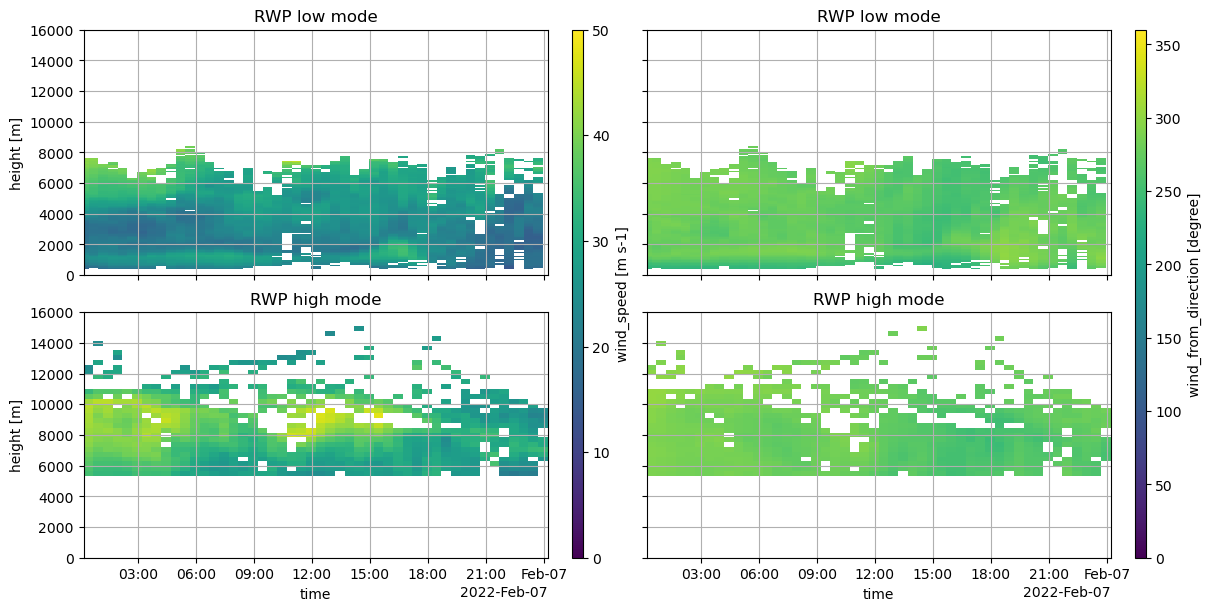

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True, constrained_layout=True)
RWP_low_mode["wspeed"].plot(
    ax=ax[0, 0],
    x="time",
    vmin=0,
    vmax=50,
    cbar_kwargs={"ax": ax[:, 0], "aspect": 50, "pad": 0.01},
    extend="neither",
    ylim=[0, 16000],
)
ax[0, 0].set_xlabel("")
ax[0, 0].set_title("RWP low mode")
RWP_high_mode["wspeed"].plot(
    ax=ax[1, 0], x="time", vmin=0, vmax=50, add_colorbar=False, ylim=[0, 16000]
)
ax[1, 0].set_title("RWP high mode")

RWP_low_mode["wdir"].plot(
    ax=ax[0, 1],
    x="time",
    vmin=-0,
    vmax=360,
    cbar_kwargs={"ax": ax[:, 1], "aspect": 50, "pad": 0.01},
    extend="neither",
    ylim=[0, 16000],
)
ax[0, 1].set_xlabel("")
ax[0, 1].set_ylabel("")
ax[0, 1].set_title("RWP low mode")
RWP_high_mode["wdir"].plot(
    ax=ax[1, 1], x="time", vmin=0, vmax=360, add_colorbar=False, ylim=[0, 16000]
)
ax[1, 1].set_ylabel("")
ax[1, 1].set_title("RWP high mode")

for axis in ax.flatten():
    axis.grid()

## Retrieve Aeolus data for the ground-site geolocation and measurement time

In [8]:
# get location and time-range from ground-based RWP data
longitude_collocated = float(RWP_low_mode["lon"])
latitude_collocated = float(RWP_low_mode["lat"])
time_collocated_min = RWP_low_mode["time"].min().values.astype("datetime64[s]")
time_collocated_max = RWP_low_mode["time"].max().values.astype("datetime64[s]")

In [9]:
# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start = str(time_collocated_min)
measurement_stop = str(time_collocated_max)

In [10]:
# Product parameters to retrieve

# Rayleigh wind fields
parameter_rayleigh = [
    "wind_result_start_time",
    "wind_result_stop_time",
    "wind_result_COG_time",
    "wind_result_bottom_altitude",
    "wind_result_top_altitude",
    "wind_result_COG_altitude",
    "wind_result_range_bin_number",
    "wind_result_start_latitude",
    "wind_result_start_longitude",
    "wind_result_stop_latitude",
    "wind_result_stop_longitude",
    "wind_result_COG_latitude",
    "wind_result_COG_longitude",
    "wind_result_HLOS_error",
    "wind_result_wind_velocity",
    "wind_result_observation_type",
    "wind_result_validity_flag",
    "wind_result_alt_of_DEM_intersection",
    "wind_result_los_azimuth",
]
parameter_rayleigh = ["rayleigh_" + param for param in parameter_rayleigh]

# Mie wind fields
parameter_mie = [
    "wind_result_start_time",
    "wind_result_stop_time",
    "wind_result_COG_time",
    "wind_result_bottom_altitude",
    "wind_result_top_altitude",
    "wind_result_COG_altitude",
    "wind_result_range_bin_number",
    "wind_result_start_latitude",
    "wind_result_start_longitude",
    "wind_result_stop_latitude",
    "wind_result_stop_longitude",
    "wind_result_COG_latitude",
    "wind_result_COG_longitude",
    "wind_result_HLOS_error",
    "wind_result_wind_velocity",
    "wind_result_observation_type",
    "wind_result_validity_flag",
    "wind_result_alt_of_DEM_intersection",
    "wind_result_los_azimuth",
]
parameter_mie = ["mie_" + param for param in parameter_mie]

In [11]:
# Data request for SCA aerosol product
request = AeolusRequest()

request.set_collection("ALD_U_N_2B")

# set observation fields
request.set_fields(rayleigh_wind_fields=parameter_rayleigh, mie_wind_fields=parameter_mie)

# Set bounding box for the area around the ground-site geolocation
request.set_bbox(
    {
        "n": latitude_collocated + 2,
        "w": longitude_collocated - 2,
        "s": latitude_collocated - 2,
        "e": longitude_collocated + 2,
    }
)

# set start and end time and request data
data_L2B = request.get_between(
    start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
)

# Save data as xarray data set
ds_L2B = data_L2B.as_xarray()

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (0.204MB)

### Add datetime representation

In [12]:
ds_L2B["rayleigh_wind_result_COG_datetime"] = (
    ("rayleigh_wind_data"),
    nc.num2date(
        ds_L2B["rayleigh_wind_result_COG_time"],
        units="s since 2000-01-01",
        only_use_cftime_datetimes=False,
    ),
)

ds_L2B["mie_wind_result_COG_datetime"] = (
    ("mie_wind_data"),
    nc.num2date(
        ds_L2B["mie_wind_result_COG_time"],
        units="s since 2000-01-01",
        only_use_cftime_datetimes=False,
    ),
)

### Add distance to ground-site

In [13]:
# calculate distance to ground site from L2A obs center and save to list
dist_to_site_rayleigh = [
    int(distance.distance((latitude_collocated, longitude_collocated), (i, j)).km)
    for i, j in zip(
        ds_L2B["rayleigh_wind_result_COG_latitude"], ds_L2B["rayleigh_wind_result_COG_longitude"]
    )
]
ds_L2B["rayleigh_distance_to_site"] = (("rayleigh_wind_data"), dist_to_site_rayleigh)

dist_to_site_mie = [
    int(distance.distance((latitude_collocated, longitude_collocated), (i, j)).km)
    for i, j in zip(ds_L2B["mie_wind_result_COG_latitude"], ds_L2B["mie_wind_result_COG_longitude"])
]
ds_L2B["mie_distance_to_site"] = (("mie_wind_data"), dist_to_site_mie)

### Create mask for observation type and validity flag

In [14]:
rayleigh_mask = np.zeros(ds_L2B.dims["rayleigh_wind_data"], dtype=bool)
# mask invalid observations
rayleigh_mask = rayleigh_mask | (ds_L2B["rayleigh_wind_result_validity_flag"] == 0)
# only Rayleigh-clear observations (1=cloudy, 2=clear)
rayleigh_mask = rayleigh_mask | (ds_L2B["rayleigh_wind_result_observation_type"] != 2)

mie_mask = np.zeros(ds_L2B.dims["mie_wind_data"], dtype=bool)
# mask invalid observations
mie_mask = mie_mask | (ds_L2B["mie_wind_result_validity_flag"] == 0)
# only Mie-cloudy observations (1=cloudy, 2=clear)
mie_mask = mie_mask | (ds_L2B["mie_wind_result_observation_type"] != 1)

/opt/conda/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


## Plot overview map of ground-site and collocated Aeolus measurements

Text(0.5, 0.98, 'Aeolus orbit \n from 2022-02-06T05:20:58 to 2022-02-06T05:21:58')

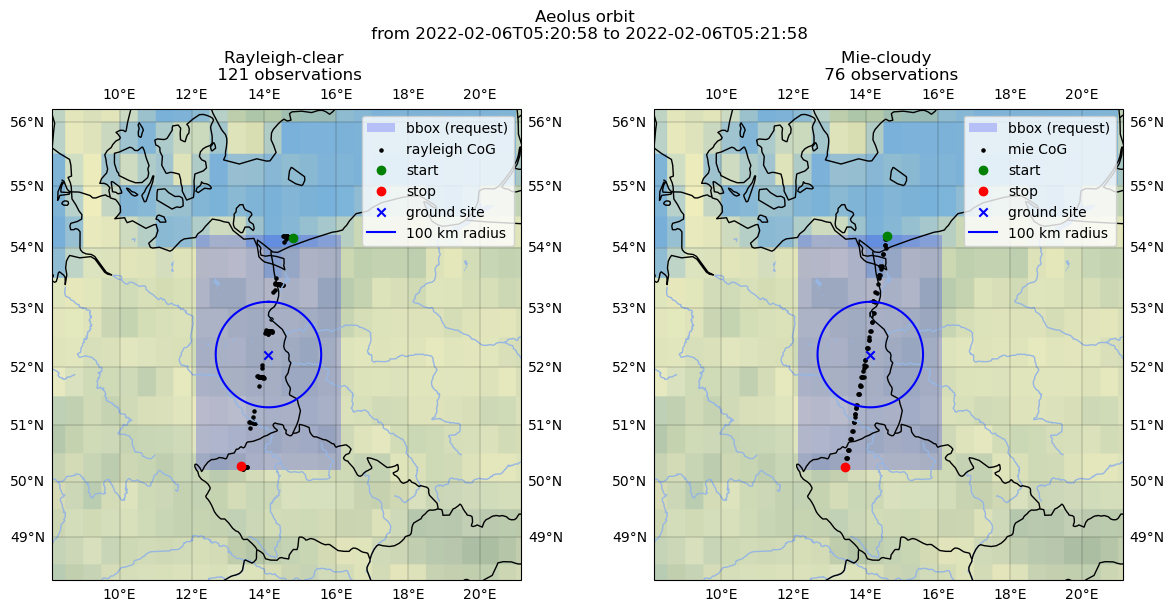

In [15]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(12, 6),
    sharey=True,
    subplot_kw={"projection": ccrs.Mercator(central_longitude=longitude_collocated)},
    constrained_layout=True,
)
# ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=longitude_collocated))
for ax, channel, mask, obs_type in zip(
    axes, ["rayleigh", "mie"], [rayleigh_mask, mie_mask], ["clear", "cloudy"]
):
    ax.set_extent(
        [
            longitude_collocated - 6,
            longitude_collocated + 7,
            latitude_collocated - 4,
            latitude_collocated + 4,
        ],
        crs=ccrs.PlateCarree(),
    )
    ax.stock_img()
    ax.add_feature(feature.LAKES)
    ax.add_feature(feature.RIVERS, linestyle="-")
    ax.add_feature(feature.BORDERS.with_scale("50m"), linestyle="-")
    ax.coastlines(resolution="50m")
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")

    ax.add_patch(
        Rectangle(
            xy=[longitude_collocated - 2, latitude_collocated - 2],
            width=4,
            height=4,
            facecolor="blue",
            alpha=0.2,
            transform=ccrs.PlateCarree(),
            label="bbox (request)",
        )
    )
    ax.scatter(
        ds_L2B[channel + "_wind_result_COG_longitude"][~mask],
        ds_L2B[channel + "_wind_result_COG_latitude"][~mask],
        marker="o",
        c="k",
        s=5,
        label=channel + " CoG",
        transform=ccrs.Geodetic(),
    )
    ax.scatter(
        ds_L2B[channel + "_wind_result_COG_longitude"][~mask][0],
        ds_L2B[channel + "_wind_result_COG_latitude"][~mask][0],
        marker="o",
        c="g",
        edgecolor="g",
        label="start",
        transform=ccrs.Geodetic(),
    )
    ax.scatter(
        ds_L2B[channel + "_wind_result_COG_longitude"][~mask][-1],
        ds_L2B[channel + "_wind_result_COG_latitude"][~mask][-1],
        marker="o",
        c="r",
        edgecolor="r",
        label="stop",
        transform=ccrs.Geodetic(),
    )
    ax.scatter(
        longitude_collocated,
        latitude_collocated,
        marker="x",
        c="b",
        # edgecolor="b",
        label="ground site",
        transform=ccrs.Geodetic(),
    )

    circle = geodesic.Geodesic().circle(
        longitude_collocated, latitude_collocated, 100000, 180, True
    )
    ax.plot(circle[:, 0], circle[:, 1], "b-", transform=ccrs.Geodetic(), label="100 km radius")

    ax.legend()
    ax.set_title(f"{channel.title()}-{obs_type} \n {np.sum(~mask).values} observations")

fig.suptitle(
    "Aeolus orbit \n from {} to {}".format(
        ds_L2B["rayleigh_wind_result_COG_datetime"][0].values.astype("datetime64[s]"),
        ds_L2B["rayleigh_wind_result_COG_datetime"][-1].values.astype("datetime64[s]"),
    )
)

## Temporal collocation
We now look for the closest RWP profile in time for each L2B observation for RWP high (hm) and low mode (lm).  
To be more accurate one can also look for the two closest profiles and apply a weighting average (e.g. with np.argsort).

In [16]:
# closest RWP profile low mode for L2B Rayleigh
idx_RWP_profile_lm_rayleigh = np.argmin(
    np.abs(
        ds_L2B["rayleigh_wind_result_COG_datetime"].values[:, None] - RWP_low_mode["time"].values
    ),
    axis=1,
)
# closest RWP profile high mode for L2B Rayleigh
idx_RWP_profile_hm_rayleigh = np.argmin(
    np.abs(
        ds_L2B["rayleigh_wind_result_COG_datetime"].values[:, None] - RWP_high_mode["time"].values
    ),
    axis=1,
)
# closest RWP profile low mode for L2B Mie
idx_RWP_profile_lm_mie = np.argmin(
    np.abs(ds_L2B["mie_wind_result_COG_datetime"].values[:, None] - RWP_low_mode["time"].values),
    axis=1,
)
# closest RWP profile high mode for L2B Mie
idx_RWP_profile_hm_mie = np.argmin(
    np.abs(ds_L2B["mie_wind_result_COG_datetime"].values[:, None] - RWP_high_mode["time"].values),
    axis=1,
)

### Plot RWP profiles and L2B observations
The same RWP profile (no. 10, see above) is the closest for every L2B observations. So we just plot only this RWP profile.  
Note that we have first to convert u- and v-wind component from RWP measurements to HLOS.
For this, we take the median value of the los-azimuth angle from all rayleigh measurements.

In [17]:
# Additionally mask observations outside of 100 km and an error estimate greater than 850 cm/s
rayleigh_mask_QC = (
    rayleigh_mask
    | (ds_L2B["rayleigh_distance_to_site"] > 100)
    | (ds_L2B["rayleigh_wind_result_HLOS_error"] > 850)
)
# Additionally mask observations outside of 100 km and an error estimate greater than 500 cm/s
mie_mask_QC = (
    mie_mask | (ds_L2B["mie_distance_to_site"] > 100) | (ds_L2B["mie_wind_result_HLOS_error"] > 500)
)
RWP_low_mode_hlos = -RWP_low_mode["u"][10] * np.sin(
    np.deg2rad(np.median(ds_L2B["rayleigh_wind_result_los_azimuth"]))
) - RWP_low_mode["v"][10] * np.cos(
    np.deg2rad(np.median(ds_L2B["rayleigh_wind_result_los_azimuth"]))
)
RWP_high_mode_hlos = -RWP_high_mode["u"][10] * np.sin(
    np.deg2rad(np.median(ds_L2B["rayleigh_wind_result_los_azimuth"]))
) - RWP_high_mode["v"][10] * np.cos(
    np.deg2rad(np.median(ds_L2B["rayleigh_wind_result_los_azimuth"]))
)

Text(0.5, 0.98, 'Aeolus orbit \n from 2022-02-06T05:20:58 to 2022-02-06T05:21:58 \n compared with Lindenberg RWP')

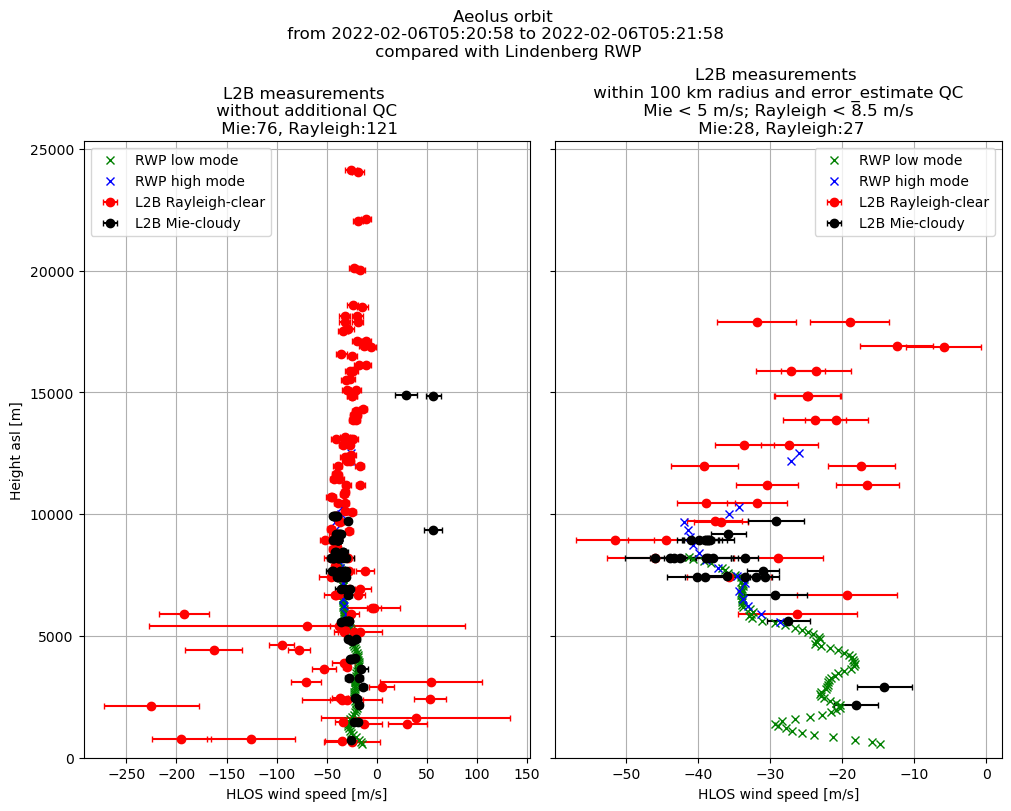

In [18]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 8), constrained_layout=True)
for ax, mask in zip(axes, [[rayleigh_mask, mie_mask], [rayleigh_mask_QC, mie_mask_QC]]):
    ax.errorbar(
        ds_L2B["rayleigh_wind_result_wind_velocity"][~mask[0]] / 100,
        ds_L2B["rayleigh_wind_result_COG_altitude"][~mask[0]],
        xerr=ds_L2B["rayleigh_wind_result_HLOS_error"][~mask[0]] / 100,
        fmt="ro",
        label="L2B Rayleigh-clear",
        capsize=2,
    )
    ax.errorbar(
        ds_L2B["mie_wind_result_wind_velocity"][~mask[1]] / 100,
        ds_L2B["mie_wind_result_COG_altitude"][~mask[1]],
        xerr=ds_L2B["mie_wind_result_HLOS_error"][~mask[1]] / 100,
        fmt="ko",
        label="L2B Mie-cloudy",
        capsize=2,
    )
    ax.plot(
        RWP_low_mode_hlos,
        RWP_low_mode["height_asl"],
        "gx",
        label="RWP low mode",
    )
    ax.plot(
        RWP_high_mode_hlos,
        RWP_high_mode["height_asl"],
        "bx",
        label="RWP high mode",
    )
    ax.legend()
    ax.grid()
    ax.set_xlabel("HLOS wind speed [m/s]")
    ax.set_ylim(0)
axes[0].set_ylabel("Height asl [m]")
axes[0].set_title(
    f"L2B measurements \n without additional QC \n Mie:{int(np.sum(~mie_mask))}, Rayleigh:{int(np.sum(~rayleigh_mask))}"
)
axes[1].set_title(
    f"L2B measurements \n within 100 km radius and error_estimate QC \n Mie < 5 m/s; Rayleigh < 8.5 m/s \n Mie:{int(np.sum(~mie_mask_QC))}, Rayleigh:{int(np.sum(~rayleigh_mask_QC))}"
)

fig.suptitle(
    "Aeolus orbit \n from {} to {} \n compared with Lindenberg RWP".format(
        ds_L2B["rayleigh_wind_result_COG_datetime"][0].values.astype("datetime64[s]"),
        ds_L2B["rayleigh_wind_result_COG_datetime"][-1].values.astype("datetime64[s]"),
    )
)

## Vertical collocation
To account for the coarser vertical L2B resolution we now average all RWP range bins with its center altitude within one Aeolus range bin.

In [19]:
def vertical_collocate(channel, RWP_data, idx_RWP_profile):
    L2B_RWP_height_idx = (
        ds_L2B[channel + "_wind_result_bottom_altitude"].values[:, None]
        < RWP_data["height_asl"].values
    ) & (
        ds_L2B[channel + "_wind_result_top_altitude"].values[:, None]
        > RWP_data["height_asl"].values
    )

    # We have to do the calculations with masked arrays because for some observations all weights can be zero and numpy.average cannot deal with zero weights
    u_RWP = np.ma.average(
        RWP_data["u"][idx_RWP_profile].to_masked_array(), axis=1, weights=L2B_RWP_height_idx
    )
    v_RWP = np.ma.average(
        RWP_data["v"][idx_RWP_profile].to_masked_array(), axis=1, weights=L2B_RWP_height_idx
    )
    hlos_RWP = -u_RWP * np.sin(
        np.deg2rad(ds_L2B[channel + "_wind_result_los_azimuth"])
    ) - v_RWP * np.cos(np.deg2rad(ds_L2B[channel + "_wind_result_los_azimuth"]))

    # return RWP HLOS winds in cm/s with missing values filled with nan
    return hlos_RWP.filled(np.nan) * 100

Add RWP hlos to the xarray dataset

In [20]:
ds_L2B["rayleigh_RWP_lm_hlos"] = (
    ("rayleigh_wind_data"),
    vertical_collocate("rayleigh", RWP_low_mode, idx_RWP_profile_lm_rayleigh),
)
ds_L2B["rayleigh_RWP_hm_hlos"] = (
    ("rayleigh_wind_data"),
    vertical_collocate("rayleigh", RWP_high_mode, idx_RWP_profile_hm_rayleigh),
)
ds_L2B["mie_RWP_lm_hlos"] = (
    ("mie_wind_data"),
    vertical_collocate("mie", RWP_low_mode, idx_RWP_profile_lm_mie),
)
ds_L2B["mie_RWP_hm_hlos"] = (
    ("mie_wind_data"),
    vertical_collocate("mie", RWP_high_mode, idx_RWP_profile_hm_mie),
)

## Plot collocated and averaged RWP measurements with L2B wind observations
We create masks where we have found RWP wind measurements for an L2B observation.

In [21]:
rayleigh_mask_QC_RWP_lm = rayleigh_mask_QC | ds_L2B["rayleigh_RWP_lm_hlos"].isnull()
rayleigh_mask_QC_RWP_hm = rayleigh_mask_QC | ds_L2B["rayleigh_RWP_hm_hlos"].isnull()
mie_mask_QC_RWP_lm = mie_mask_QC | ds_L2B["mie_RWP_lm_hlos"].isnull()
mie_mask_QC_RWP_hm = mie_mask_QC | ds_L2B["mie_RWP_hm_hlos"].isnull()

Text(0.5, 1.0, 'L2B measurements \n within 100 km radius and error_estimate QC \n Mie < 5 m/s; Rayleigh < 8.5 m/s')

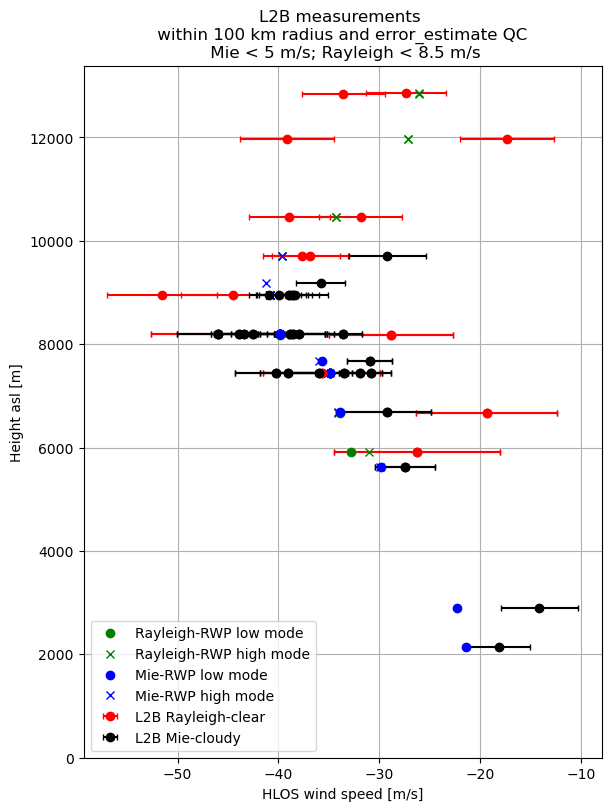

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8), constrained_layout=True)

ax.errorbar(
    ds_L2B["rayleigh_wind_result_wind_velocity"][~rayleigh_mask_QC_RWP_lm] / 100,
    ds_L2B["rayleigh_wind_result_COG_altitude"][~rayleigh_mask_QC_RWP_lm],
    xerr=ds_L2B["rayleigh_wind_result_HLOS_error"][~rayleigh_mask_QC_RWP_lm] / 100,
    fmt="ro",
    label="L2B Rayleigh-clear",
    capsize=2,
)
ax.errorbar(
    ds_L2B["rayleigh_wind_result_wind_velocity"][~rayleigh_mask_QC_RWP_hm] / 100,
    ds_L2B["rayleigh_wind_result_COG_altitude"][~rayleigh_mask_QC_RWP_hm],
    xerr=ds_L2B["rayleigh_wind_result_HLOS_error"][~rayleigh_mask_QC_RWP_hm] / 100,
    fmt="ro",
    # label="L2B Rayleigh-clear",
    capsize=2,
)


ax.errorbar(
    ds_L2B["mie_wind_result_wind_velocity"][~mie_mask_QC_RWP_lm] / 100,
    ds_L2B["mie_wind_result_COG_altitude"][~mie_mask_QC_RWP_lm],
    xerr=ds_L2B["mie_wind_result_HLOS_error"][~mie_mask_QC_RWP_lm] / 100,
    fmt="ko",
    label="L2B Mie-cloudy",
    capsize=2,
)
ax.errorbar(
    ds_L2B["mie_wind_result_wind_velocity"][~mie_mask_QC_RWP_hm] / 100,
    ds_L2B["mie_wind_result_COG_altitude"][~mie_mask_QC_RWP_hm],
    xerr=ds_L2B["mie_wind_result_HLOS_error"][~mie_mask_QC_RWP_hm] / 100,
    fmt="ko",
    # label="L2B Mie-cloudy",
    capsize=2,
)


ax.plot(
    ds_L2B["rayleigh_RWP_lm_hlos"][~rayleigh_mask_QC_RWP_lm] / 100,
    ds_L2B["rayleigh_wind_result_COG_altitude"][~rayleigh_mask_QC_RWP_lm],
    "go",
    label="Rayleigh-RWP low mode",
)
ax.plot(
    ds_L2B["rayleigh_RWP_hm_hlos"][~rayleigh_mask_QC_RWP_hm] / 100,
    ds_L2B["rayleigh_wind_result_COG_altitude"][~rayleigh_mask_QC_RWP_hm],
    "gx",
    label="Rayleigh-RWP high mode",
)


ax.plot(
    ds_L2B["mie_RWP_lm_hlos"][~mie_mask_QC_RWP_lm] / 100,
    ds_L2B["mie_wind_result_COG_altitude"][~mie_mask_QC_RWP_lm],
    "bo",
    label="Mie-RWP low mode",
)
ax.plot(
    ds_L2B["mie_RWP_hm_hlos"][~mie_mask_QC_RWP_hm] / 100,
    ds_L2B["mie_wind_result_COG_altitude"][~mie_mask_QC_RWP_hm],
    "bx",
    label="Mie-RWP high mode",
)

ax.set_ylim(0)
ax.legend()
ax.grid()
ax.set_xlabel("HLOS wind speed [m/s]")
ax.set_ylabel("Height asl [m]")
ax.set_title(
    "L2B measurements \n within 100 km radius and error_estimate QC \n Mie < 5 m/s; Rayleigh < 8.5 m/s"
)